In [25]:
import h5py
import os
import numpy as np
import pickle
import matplotlib.pyplot as plt
import scipy.ndimage as ndimage
import pandas as pd
import datetime
from sklearn.cluster import DBSCAN

In [4]:
path_to_rf_model = '/Volumes/INTENSO/kcl-ltss-bioatm/interim/models/rf_model_32_trees.pickle'
rf_model = pickle.load(open(path_to_rf_model, 'rb'))

/Users/danielfisher/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [8]:
path = '/Volumes/INTENSO/kcl-ltss-bioatm/raw/reprojected_viirs/h5'
fnames = ['GMODO-SVM01-SVM04-SVM05-SVM06-SVM07-SVM10-SVM11-SVM12-SVM15_npp_d20160702_t2001489_e2007293_b24253_c20180423092828622274_noaa_ops_reproj.h5',
          'GMODO-SVM01-SVM04-SVM05-SVM06-SVM07-SVM10-SVM11-SVM12-SVM15_npp_d20160719_t1732167_e1737571_b24492_c20180423131933425733_noaa_ops_reproj.h5',
          'GMODO-SVM01-SVM04-SVM05-SVM06-SVM07-SVM10-SVM11-SVM12-SVM15_npp_d20160720_t1714465_e1720268_b24506_c20180423131939599458_noaa_ops_reproj.h5',
          'GMODO-SVM01-SVM04-SVM05-SVM06-SVM07-SVM10-SVM11-SVM12-SVM15_npp_d20160720_t1720281_e1726085_b24506_c20180423131939638761_noaa_ops_reproj.h5',
          'GMODO-SVM01-SVM04-SVM05-SVM06-SVM07-SVM10-SVM11-SVM12-SVM15_npp_d20160731_t1710018_e1715422_b24662_c20180423155105968604_noaa_ops_reproj.h5',
          'GMODO-SVM01-SVM04-SVM05-SVM06-SVM07-SVM10-SVM11-SVM12-SVM15_npp_d20160801_t1652315_e1658119_b24676_c20180423155146626485_noaa_ops_reproj.h5',
          'GMODO-SVM01-SVM04-SVM05-SVM06-SVM07-SVM10-SVM11-SVM12-SVM15_npp_d20160822_t1700347_e1706151_b24974_c20180423160319235317_noaa_ops_reproj.h5',
          'GMODO-SVM01-SVM04-SVM05-SVM06-SVM07-SVM10-SVM11-SVM12-SVM15_npp_d20160823_t1819484_e1825288_b24989_c20180423155957524701_noaa_ops_reproj.h5',
         ]
bands = ['1', '4', '5', '6', '7', '10', '11', '12', '15']
mask_list = []

In [9]:
for fname in fnames:
    sdr_path = os.path.join(path, fname)
    sdr = h5py.File(sdr_path,  "r")
    index = 0
    for band in bands:
        # extract band data and place in array
        image = sdr['VIIRS-M' + band][:]
        grad = ndimage.filters.sobel(image)

        if index == 0:
            image_array = np.zeros((image.size, len(bands)*2))


        image_array[:, index] = image.flatten()
        image_array[:, index+1] = grad.flatten()
        index += 2
        
    mask = rf_model.predict(image_array)
    mask = mask.reshape(image.shape)
    mask_list.append(mask)
    

GMODO-SVM01-SVM04-SVM05-SVM06-SVM07-SVM10-SVM11-SVM12-SVM15_npp_d20160702_t2001489_e2007293_b24253_c20180423092828622274_noaa_ops_reproj.h5


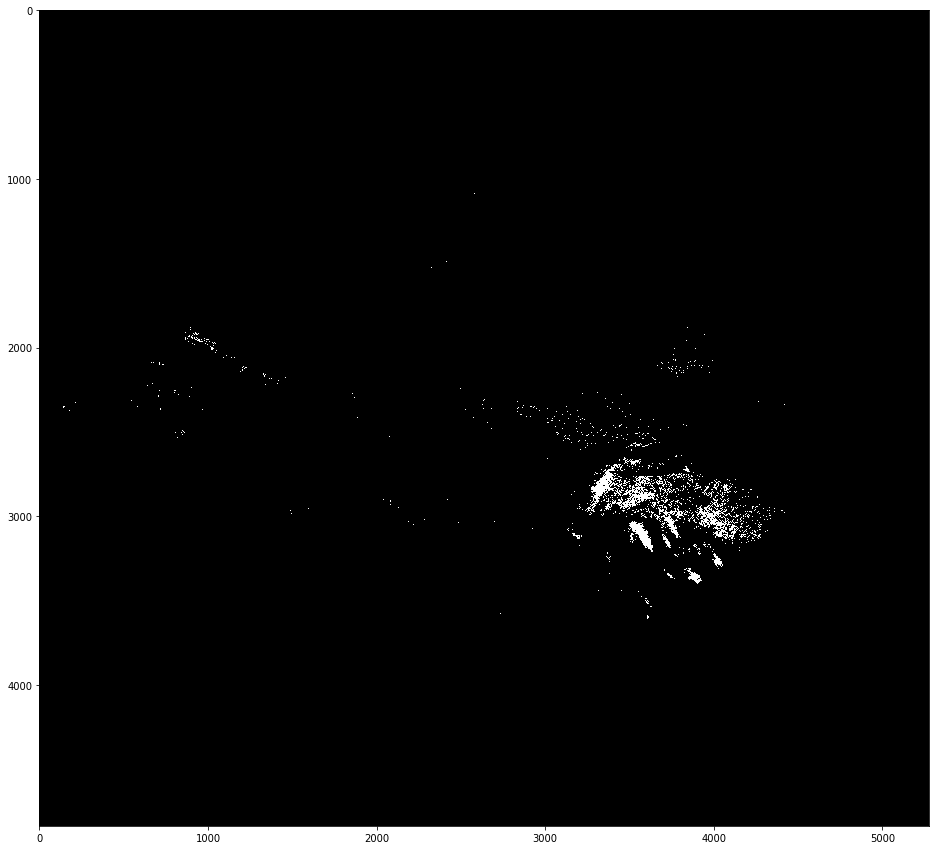



GMODO-SVM01-SVM04-SVM05-SVM06-SVM07-SVM10-SVM11-SVM12-SVM15_npp_d20160719_t1732167_e1737571_b24492_c20180423131933425733_noaa_ops_reproj.h5


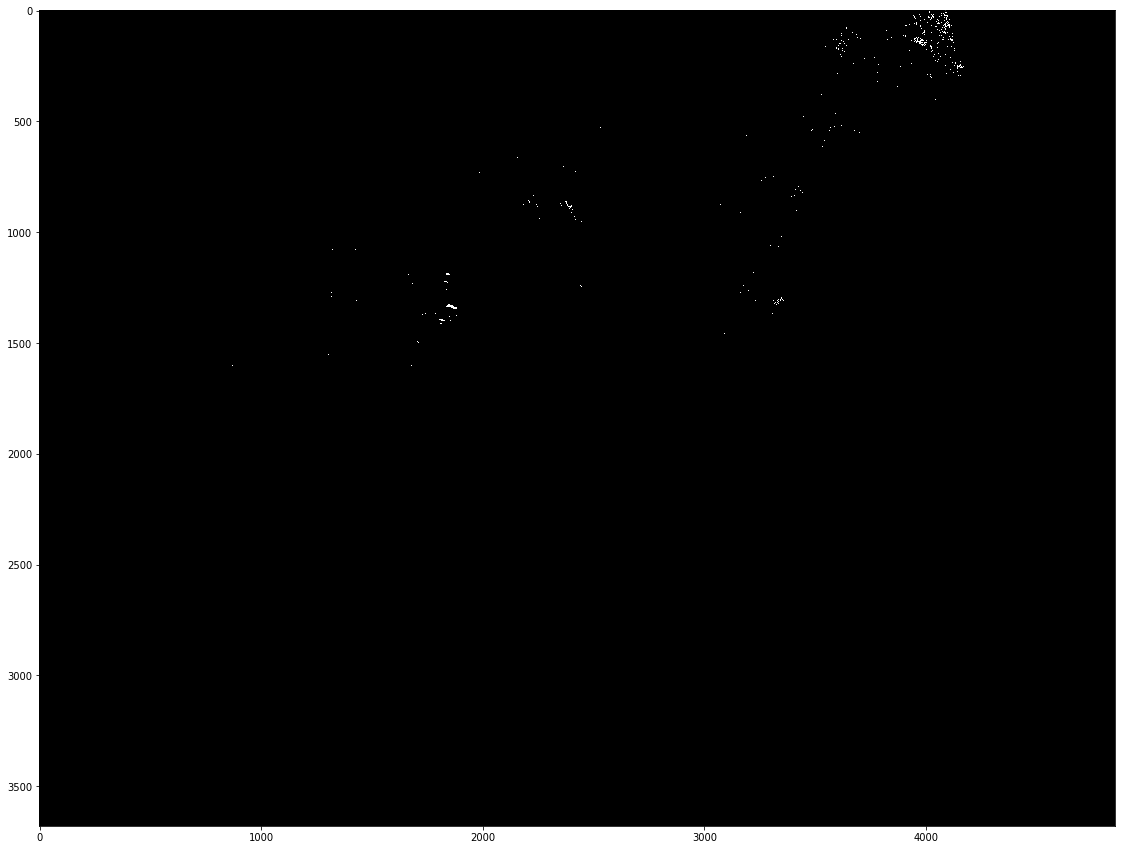



GMODO-SVM01-SVM04-SVM05-SVM06-SVM07-SVM10-SVM11-SVM12-SVM15_npp_d20160720_t1714465_e1720268_b24506_c20180423131939599458_noaa_ops_reproj.h5


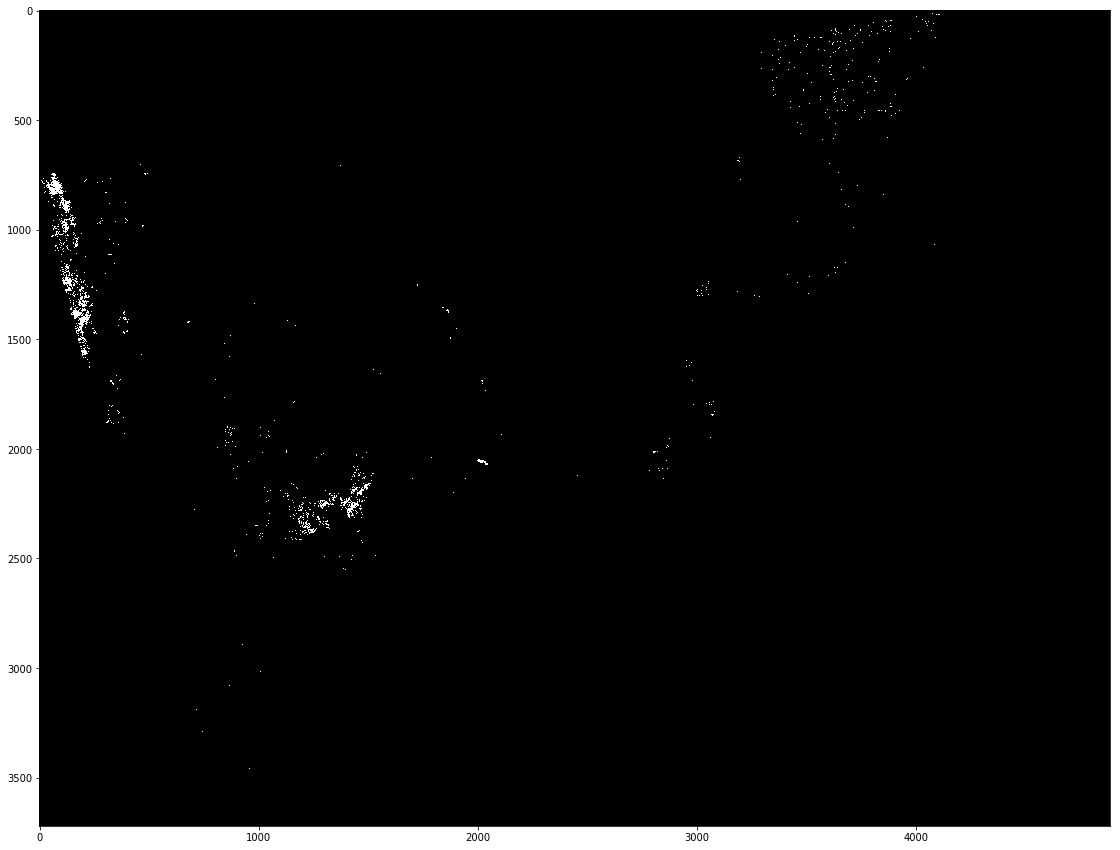



GMODO-SVM01-SVM04-SVM05-SVM06-SVM07-SVM10-SVM11-SVM12-SVM15_npp_d20160720_t1720281_e1726085_b24506_c20180423131939638761_noaa_ops_reproj.h5


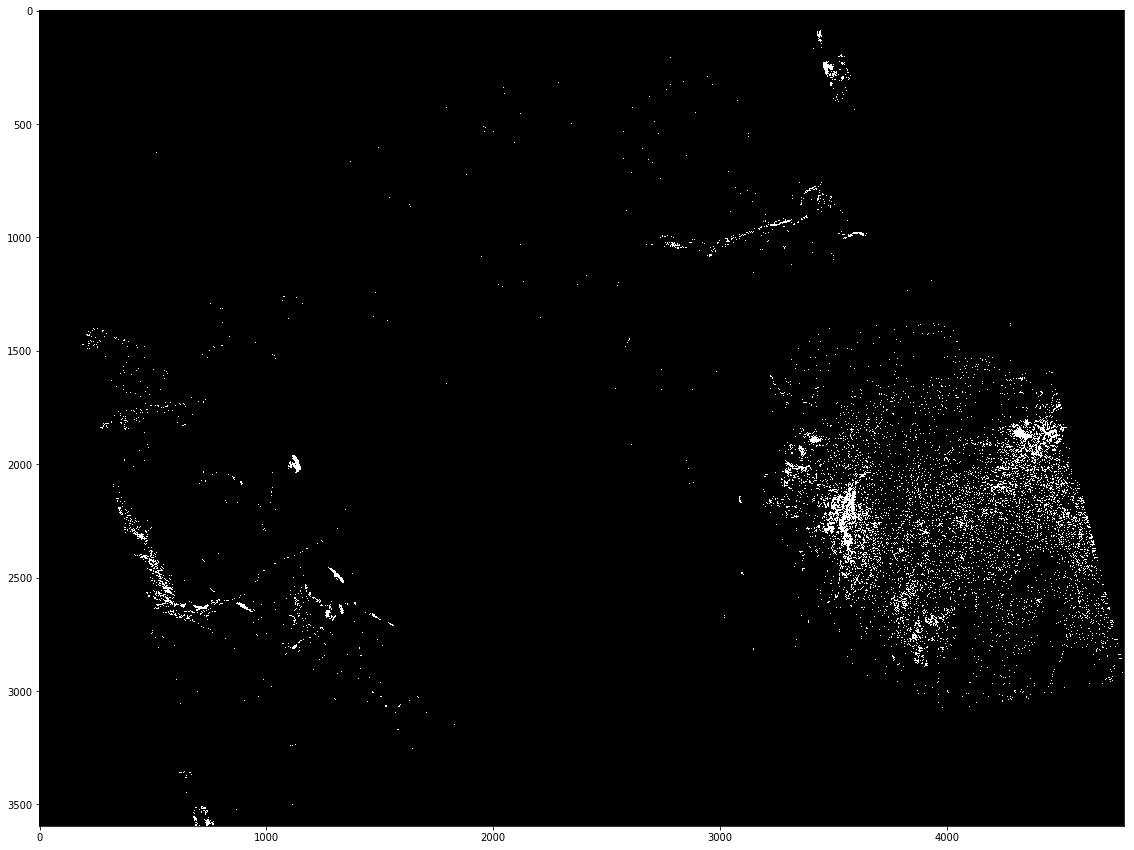



GMODO-SVM01-SVM04-SVM05-SVM06-SVM07-SVM10-SVM11-SVM12-SVM15_npp_d20160731_t1710018_e1715422_b24662_c20180423155105968604_noaa_ops_reproj.h5


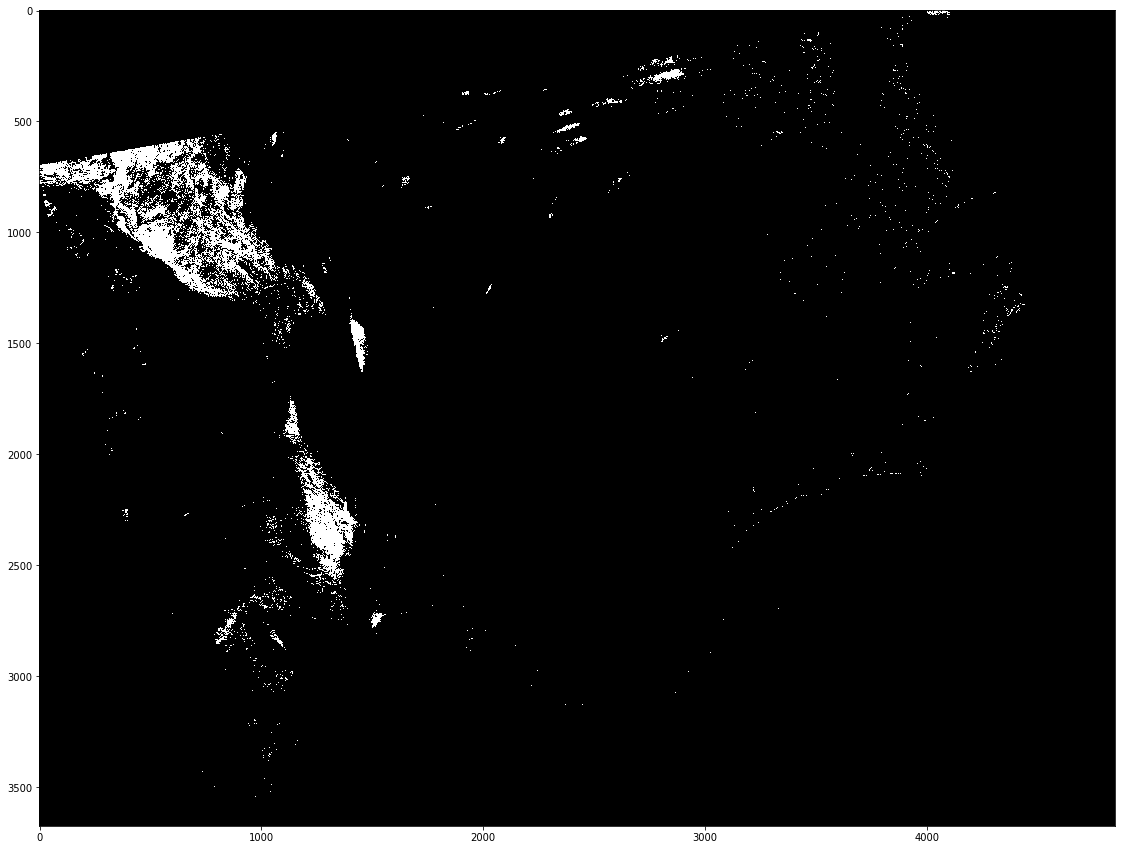



GMODO-SVM01-SVM04-SVM05-SVM06-SVM07-SVM10-SVM11-SVM12-SVM15_npp_d20160801_t1652315_e1658119_b24676_c20180423155146626485_noaa_ops_reproj.h5


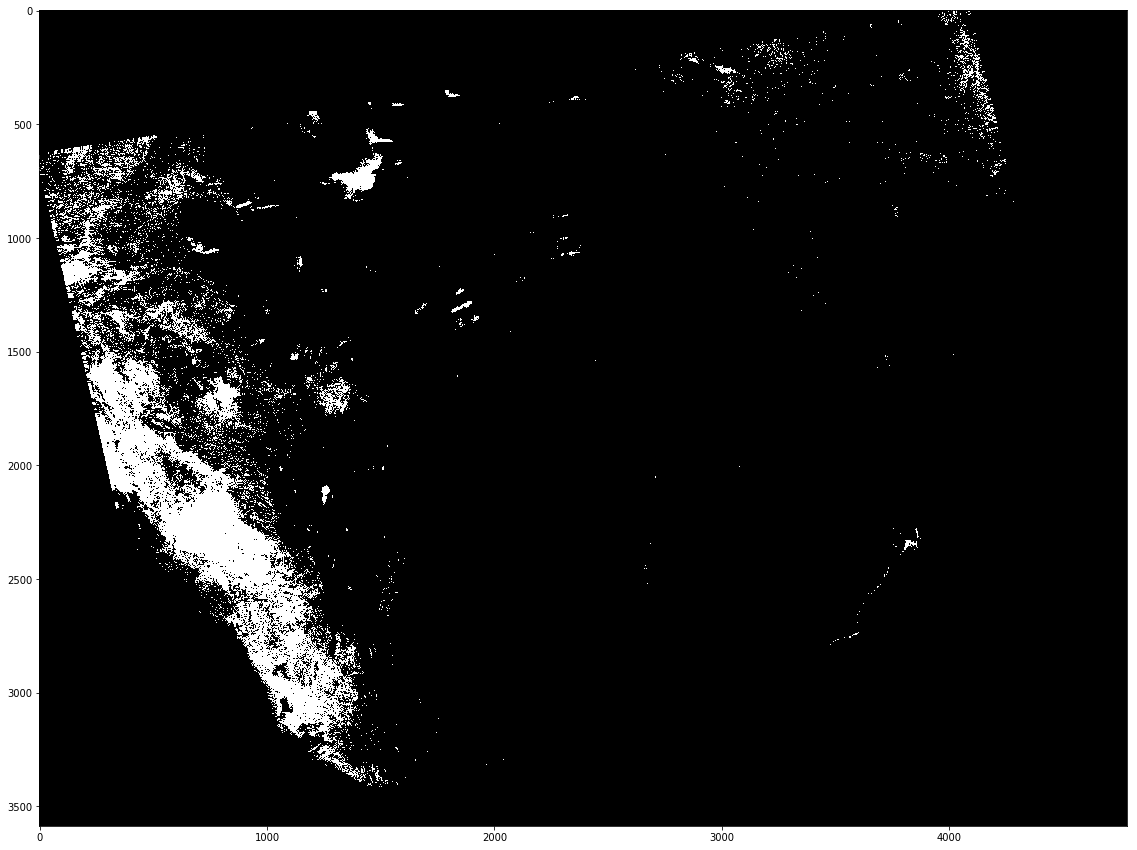



GMODO-SVM01-SVM04-SVM05-SVM06-SVM07-SVM10-SVM11-SVM12-SVM15_npp_d20160822_t1700347_e1706151_b24974_c20180423160319235317_noaa_ops_reproj.h5


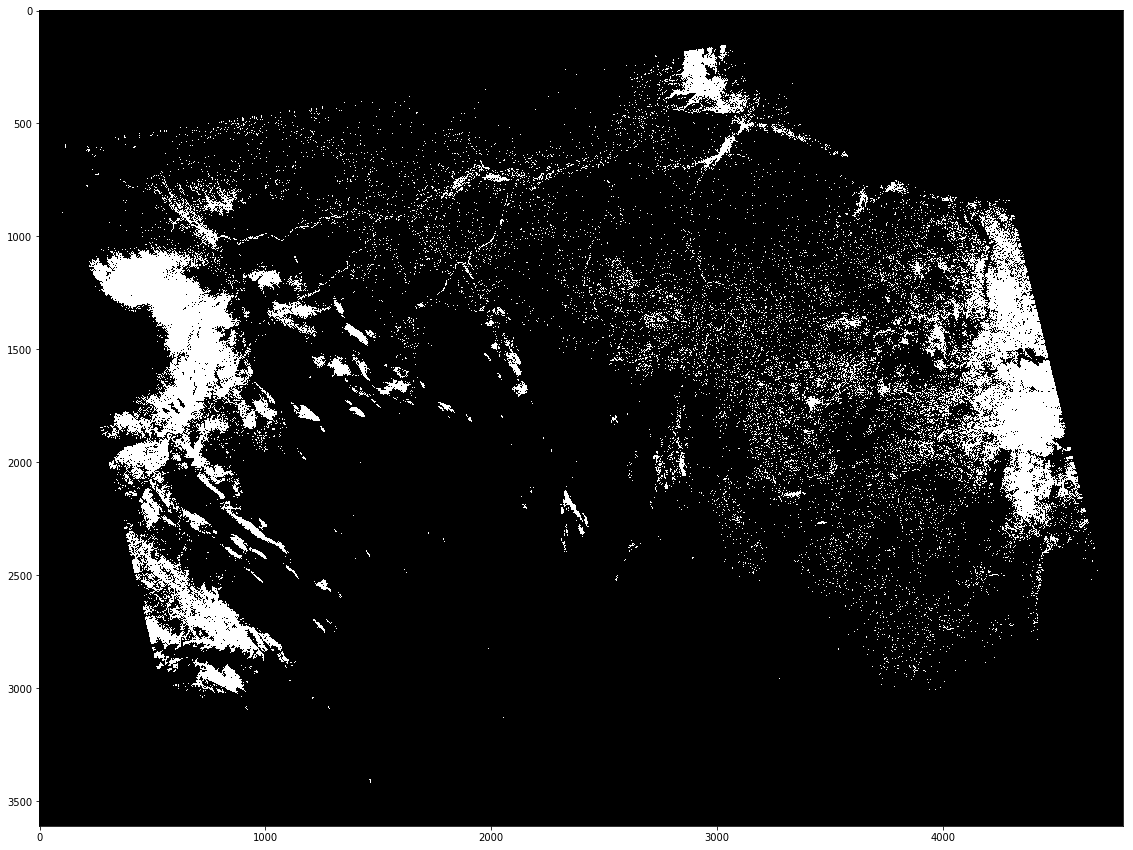



GMODO-SVM01-SVM04-SVM05-SVM06-SVM07-SVM10-SVM11-SVM12-SVM15_npp_d20160823_t1819484_e1825288_b24989_c20180423155957524701_noaa_ops_reproj.h5


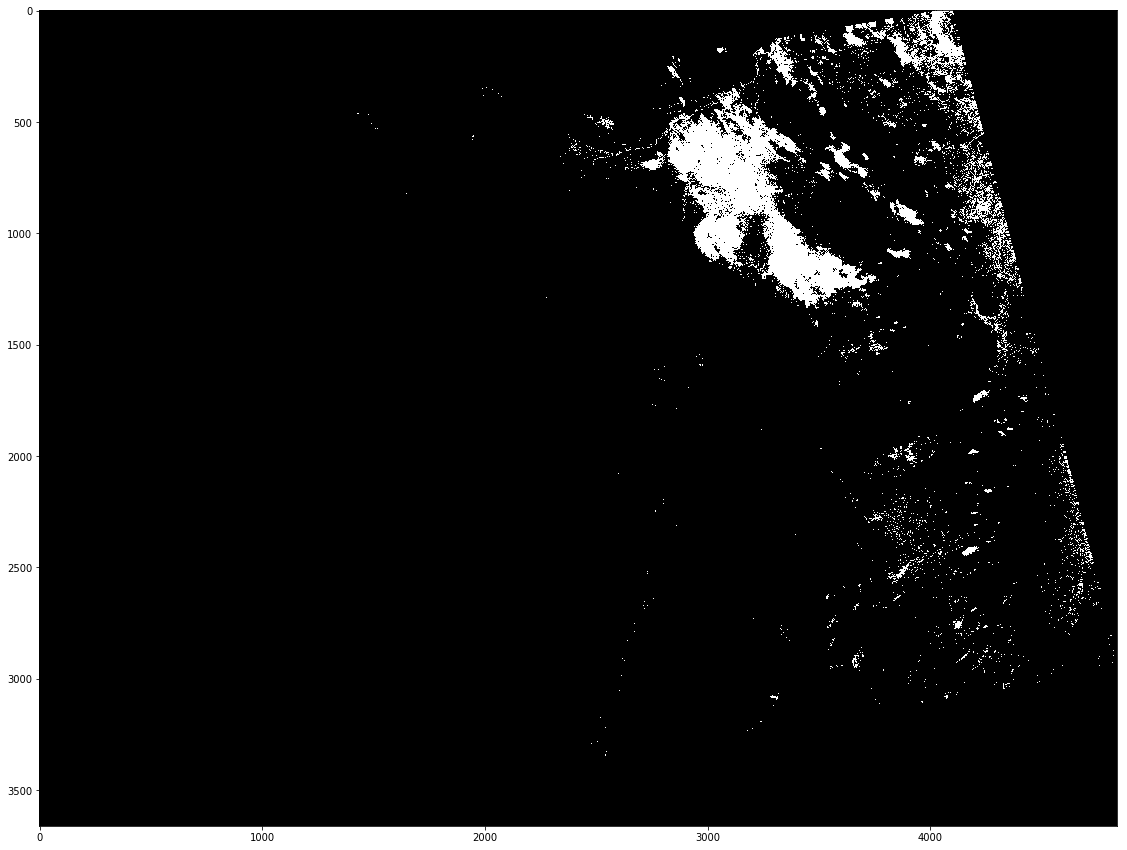

In [10]:
for mask, fname in zip(mask_list, fnames):
    print(fname)
    fig = plt.figure(figsize=(25,15))
    plt.imshow(mask, cmap='gray', interpolation='none')
    plt.show()
    print()
    print()

# Reading in fire data

In [4]:
fire_df = pd.read_csv('/Volumes/INTENSO/kcl-ltss-bioatm/raw/fires/fire_archive_V1_24485.csv')
fire_df['date_time'] = pd.to_datetime(fire_df['acq_date'])

In [18]:
def extract_fires_for_roi(df, ts, extent):
    time_subset = df[df.date_time == ts]
    time_space_subset = time_subset[((df.latitude > extent['min_lat']) &
                                    (df.latitude < extent['max_lat']) &
                                    (df.longitude > extent['min_lon']) &
                                    (df.longitude < extent['max_lon']))]
    return time_space_subset

In [51]:
date_to_find = pd.Timestamp(2016, 7, 2)
extent = {'min_lat': -10,
          'max_lat': 10,
          'min_lon': -39,
          'max_lon': -38}
image_fires_df = extract_fires_for_roi(fire_df, date_to_find, extent)

/Users/danielfisher/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [52]:
coords = image_fires_df[['latitude', 'longitude']].values
dist_in_km = 2
db = DBSCAN(eps=dist_in_km/6371., min_samples=1, algorithm='ball_tree', metric='haversine').fit(np.radians(coords))
image_fires_df['cluster_id'] = db.labels_

In [53]:
image_fires_df

,latitude,longitude,bright_ti4,scan,track,acq_date,acq_time,satellite,instrument,confidence,version,bright_ti5,frp,date_time,cluster_id
8671,-3.58349,-38.85451,328.2,0.53,0.42,2016-07-02,341,N,VIIRS,n,1,292.6,4.4,2016-07-02,0
8672,-3.58659,-38.85997,334.8,0.54,0.42,2016-07-02,341,N,VIIRS,n,1,286.7,4.4,2016-07-02,0
8673,-3.58581,-38.86479,320.0,0.54,0.42,2016-07-02,341,N,VIIRS,n,1,284.0,4.5,2016-07-02,0
8674,-3.59046,-38.86059,308.7,0.54,0.42,2016-07-02,341,N,VIIRS,n,1,284.4,1.5,2016-07-02,0
8675,-3.59433,-38.86121,303.9,0.54,0.42,2016-07-02,341,N,VIIRS,n,1,280.5,1.5,2016-07-02,0
12295,-5.74326,-38.99769,337.3,0.50,0.41,2016-07-02,1620,N,VIIRS,n,1,307.5,4.2,2016-07-02,1
12299,-5.50769,-38.14240,338.9,0.56,0.43,2016-07-02,1620,N,VIIRS,n,1,307.9,3.0,2016-07-02,2
12415,-4.14283,-38.26952,340.0,0.57,0.43,2016-07-02,1620,N,VIIRS,n,1,300.6,8.1,2016-07-02,3
12437,-3.59067,-38.86298,335.6,0.54,0.42,2016-07-02,1620,N,VIIRS,n,1,300.0,7.4,2016-07-02,0
12438,-3.58679,-38.86356,337.0,0.54,0.42,2016-07-02,1620,N,VIIRS,n,1,300.7,12.3,2016-07-02,0
